Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sentiment columns: ['timestamp', 'value', 'classification', 'date']
Trader columns   : ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Sample sentiment dates: 0    2018-02-01
1    2018-02-02
2    2018-02-03
3    2018-02-04
4    2018-02-05
Name: date, dtype: object
Sample trade dates    : 0    2024-10-27
1    2024-10-27
2    2024-10-27
3    2024-10-27
4    2024-10-27
Name: date, dtype: object
Merged dataset shape: (211224, 24)
Unique sentiment classes: ['Greed' 'Neutral' nan 'Extreme Greed']

=== Summary by Sentiment ===
               trades   mean_pnl  median_pnl     avg_size
sent_class                                               
Greed           36289  87.894859         0.0  3182.883845
Neutral 

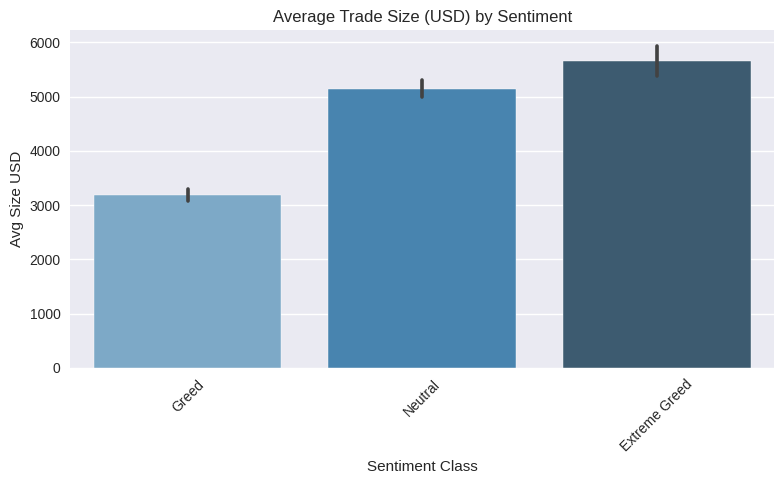

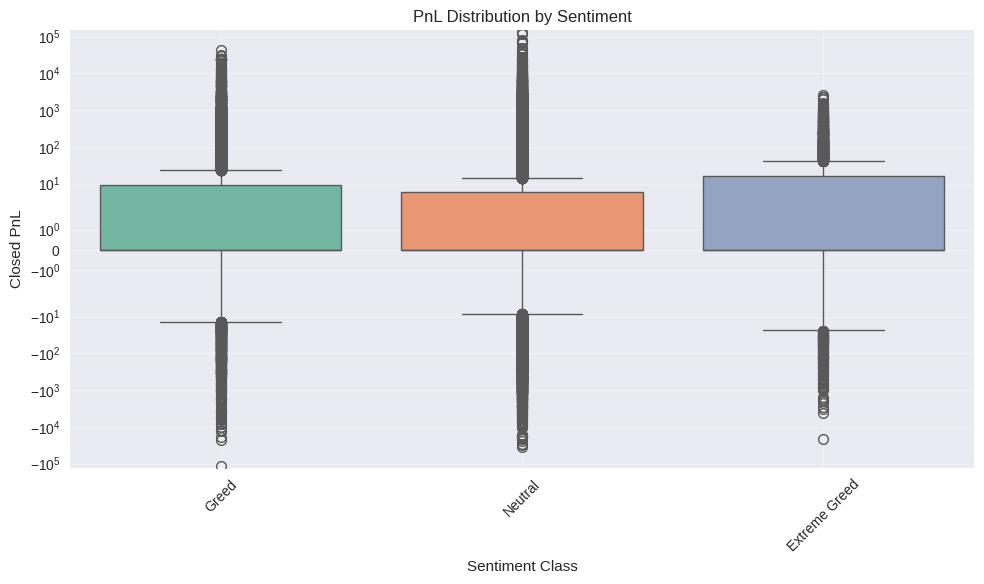

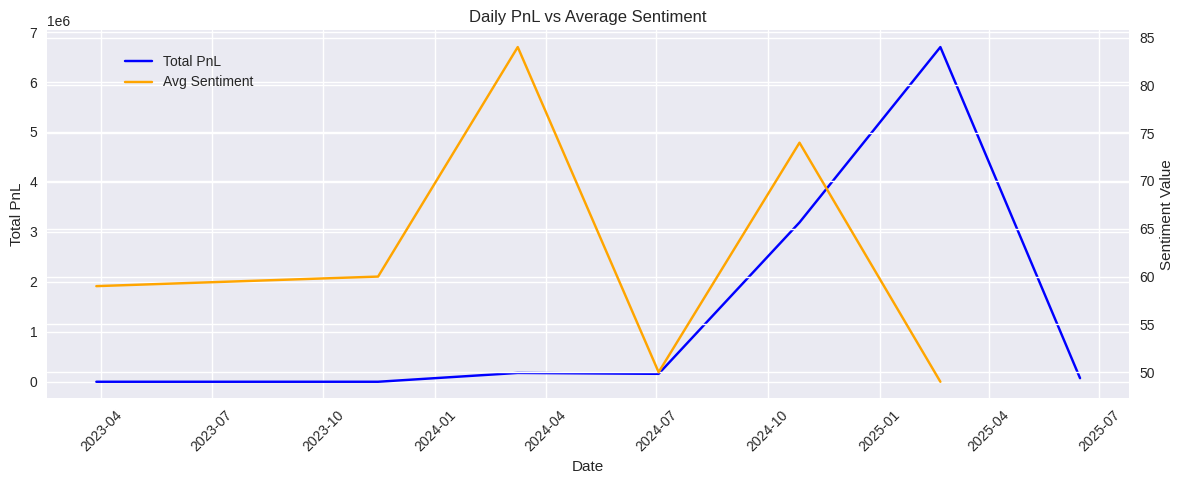

In [5]:

from google.colab import drive
drive.mount('/content/drive')

import os
BASE = "/content/drive/MyDrive/ds_dataset/"
os.makedirs(BASE + "csv_files", exist_ok=True)
os.makedirs(BASE + "outputs", exist_ok=True)

import pandas as pd
import numpy as np

sentiment_fp = BASE + "csv_files/fear_greed_index.csv"
trader_fp    = BASE + "csv_files/historical_data.csv"

df_sent = pd.read_csv(sentiment_fp)
df_tr   = pd.read_csv(trader_fp)

print("Sentiment columns:", df_sent.columns.tolist())
print("Trader columns   :", df_tr.columns.tolist())


def clean_cols(df):
    """
    Standardizes column names: lowercase, remove spaces, replace with underscores.
    """
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

df_sent = clean_cols(df_sent)
df_tr   = clean_cols(df_tr)


def epoch_to_dt(series, fallback=None, tz="Asia/Kolkata"):
    """
    Converts numeric or string timestamps to datetime with timezone.
    Handles seconds, milliseconds, microseconds.
    """
    numeric = pd.to_numeric(series, errors="coerce")

    def one(x):
        if pd.isna(x): return pd.NaT
        if x > 1e14: return pd.to_datetime(x, unit="us", utc=True)
        if x > 1e12: return pd.to_datetime(x, unit="ms", utc=True)
        if x > 1e9:  return pd.to_datetime(x, unit="s", utc=True)
        return pd.to_datetime(x, errors="coerce", utc=True)

    dt = numeric.apply(one)
    if dt.notna().sum() == 0 and fallback is not None:
        dt = pd.to_datetime(fallback, errors="coerce")
        if dt.dt.tz is None:
            dt = dt.dt.tz_localize(tz)
    else:
        dt = dt.dt.tz_convert(tz)
    return dt


df_sent["dt"] = epoch_to_dt(df_sent.get("timestamp"), fallback=df_sent.get("date"))
df_tr["dt"]   = epoch_to_dt(df_tr.get("timestamp"), fallback=df_tr.get("timestamp_ist"))


df_sent["date"] = pd.to_datetime(df_sent["dt"]).dt.date
df_tr["date"]   = pd.to_datetime(df_tr["dt"]).dt.date

print("Sample sentiment dates:", df_sent["date"].head())
print("Sample trade dates    :", df_tr["date"].head())

df = pd.merge(
    df_tr,
    df_sent[["date","value","classification"]],
    on="date",
    how="left"
)


df_sent_daily = df_sent.sort_values("date").drop_duplicates("date").set_index("date")
df_sent_daily["value_ffill"] = df_sent_daily["value"].ffill()
df_sent_daily["class_ffill"] = df_sent_daily["classification"].ffill()

df = df.merge(
    df_sent_daily[["value_ffill","class_ffill"]],
    how="left",
    left_on="date",
    right_index=True
)


df["sent_value"] = df["value_ffill"].fillna(df["value"])
df["sent_class"] = df["class_ffill"].fillna(df["classification"])

print("Merged dataset shape:", df.shape)
print("Unique sentiment classes:", df["sent_class"].unique())


if "side" in df.columns:
    df["is_buy"] = df["side"].str.lower().eq("buy").astype(int)


if "closed_pnl" in df.columns:
    df["pnl_positive"] = (df["closed_pnl"] > 0).astype(int)


df["hour"] = df["dt"].dt.hour
df["weekday"] = df["dt"].dt.day_name()

bins = [0,6,12,18,24]
labels = ["Night","Morning","Afternoon","Evening"]
df["time_bin"] = pd.cut(df["hour"], bins=bins, labels=labels, right=False)


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")


if "closed_pnl" in df.columns and "size_usd" in df.columns:
    agg = df.groupby("sent_class").agg(
        trades=("pnl_positive","count"),
        mean_pnl=("closed_pnl","mean"),
        median_pnl=("closed_pnl","median"),
        avg_size=("size_usd","mean")
    ).sort_values("mean_pnl", ascending=False)
    print("\n=== Summary by Sentiment ===")
    print(agg)


if "size_usd" in df.columns and not df.empty:
    plt.figure(figsize=(8,5))
    sns.barplot(x=df["sent_class"], y=df["size_usd"], palette="Blues_d")
    plt.title("Average Trade Size (USD) by Sentiment")
    plt.ylabel("Avg Size USD")
    plt.xlabel("Sentiment Class")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(BASE + "outputs/avg_size_by_sentiment.png", dpi=150)
    plt.show()

if "closed_pnl" in df.columns and df["closed_pnl"].notna().any():
    plt.figure(figsize=(10,6))
    sns.boxplot(x="sent_class", y="closed_pnl", data=df, palette="Set2")
    plt.yscale("symlog")
    plt.title("PnL Distribution by Sentiment")
    plt.ylabel("Closed PnL")
    plt.xlabel("Sentiment Class")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(BASE + "outputs/pnl_boxplot_by_sentiment.png", dpi=150)
    plt.show()

if "closed_pnl" in df.columns:
    daily = df.groupby("date").agg(
        total_pnl=("closed_pnl","sum"),
        avg_sent=("sent_value","mean")
    ).reset_index()

    if not daily.empty:
        fig, ax1 = plt.subplots(figsize=(12,5))
        ax2 = ax1.twinx()
        ax1.plot(daily["date"], daily["total_pnl"], label="Total PnL", color="blue")
        ax2.plot(daily["date"], daily["avg_sent"], label="Avg Sentiment", color="orange")
        ax1.set_ylabel("Total PnL")
        ax2.set_ylabel("Sentiment Value")
        ax1.set_xlabel("Date")
        ax1.tick_params(axis='x', rotation=45)
        fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
        plt.title("Daily PnL vs Average Sentiment")
        plt.tight_layout()
        plt.savefig(BASE + "outputs/daily_pnl_vs_sentiment.png", dpi=150)
        plt.show()
